In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('dataset/multitude.csv')

In [3]:
df.head()

,text,label,multi_label,split,language,length,source
0,Der Ausbruch des Coronavirus hat die Entwicklu...,1,text-davinci-003,test,de,174,MULTITuDE_MassiveSumm_spiegel
1,Alex Azar was officially sworn in as the U.S. ...,1,text-davinci-003,train,en,57,MULTITuDE_MassiveSumm_voanews
2,Європейський союз вимагає зупинити розтрату ко...,1,gpt-3.5-turbo,test,uk,105,MULTITuDE_MassiveSumm_interfax
3,"Yesterday, hundreds of Zambian university stud...",1,text-davinci-003,train,en,254,MULTITuDE_MassiveSumm_voanews
4,"In a narrow and highly watched vote, the US Se...",1,gpt-4,train,en,416,MULTITuDE_MassiveSumm_voanews


In [4]:
unique_languages = df['language'].unique()
print(unique_languages)

for language in unique_languages:
    average_length = df[df['language'] == language]['length'].mean()
    print(f"Average length for language {language}: {average_length}")

print("average_length_total", df['length'].mean())

['de' 'en' 'uk' 'es' 'nl' 'ca' 'ru' 'pt' 'ar' 'zh' 'cs']
Average length for language de: 116.7731843575419
Average length for language en: 209.63703326544467
Average length for language uk: 72.09032983508246
Average length for language es: 155.25901950630072
Average length for language nl: 156.79109461966604
Average length for language ca: 165.20958751393533
Average length for language ru: 71.82725859388495
Average length for language pt: 146.3034044145155
Average length for language ar: 70.53348297792742
Average length for language zh: 98.40216175922475
Average length for language cs: 103.49572331721829
average_length_total 152.55296229802514


In [5]:
max_length = df['length'].max()
print(max_length)

512


In [6]:
test_df = df[df['split'] == 'test']
train_df = df[df['split'] == 'train']

test_df 1    26059
0     3236
Name: label, dtype: int64
train_df 1    40030
0     4756
Name: label, dtype: int64


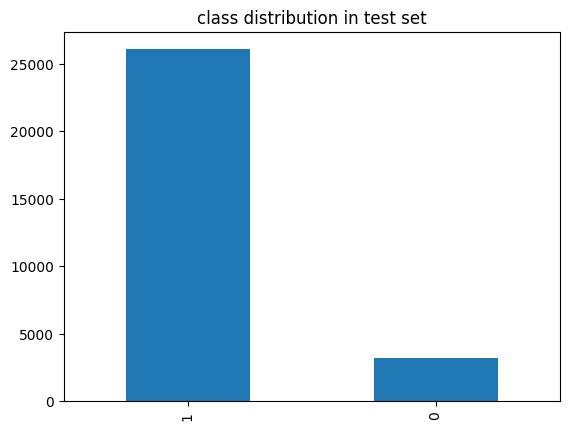

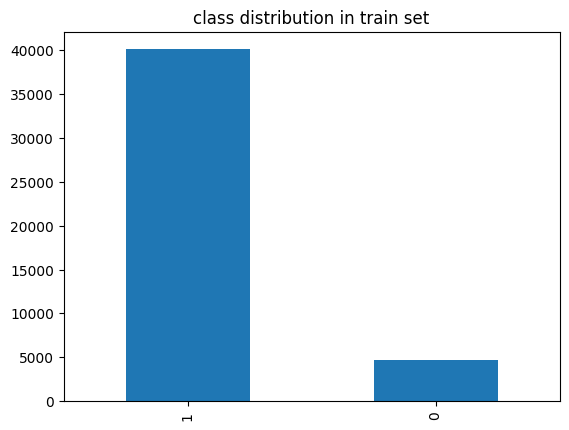

In [8]:
# number of samples as label 0 or 1 in test and train
print("test_df", test_df['label'].value_counts())
print("train_df", train_df['label'].value_counts())

# graph of the number of samples as label 0 or 1 in test and train
import matplotlib.pyplot as plt

test_df['label'].value_counts().plot(kind='bar')
plt.title('class distribution in test set')
plt.show()

train_df['label'].value_counts().plot(kind='bar')
plt.title('class distribution in train set')
plt.show()


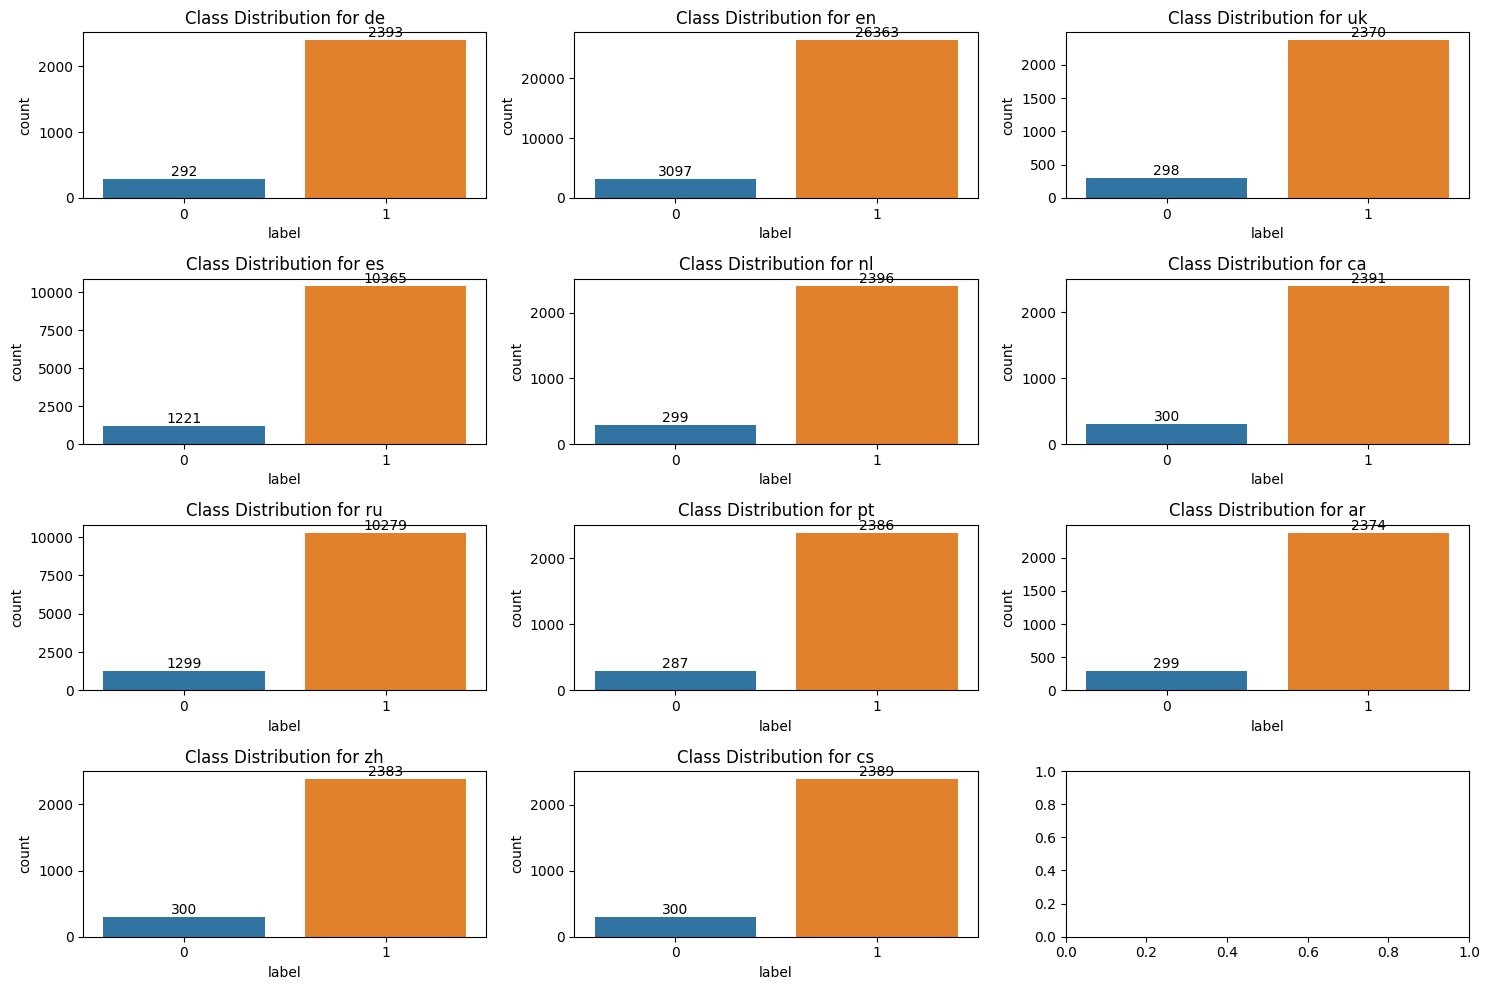

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grid of plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Iterate over unique languages
for i, language in enumerate(unique_languages):
    # Filter the dataframe for the specific language
    language_df = df[df['language'] == language]
    
    # Plot the class distribution
    ax = axes[i // 3, i % 3]
    sns.countplot(data=language_df, x='label', ax=ax)
    ax.set_title(f'Class Distribution for {language}')
    
    # Add exact values to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

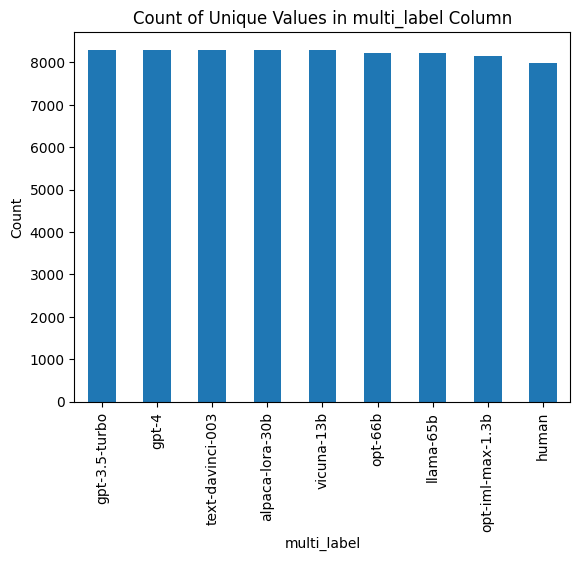

In [20]:

# Count the unique values in the multi_label column
multi_label_counts = df['multi_label'].value_counts()

# Plot the count of unique values
multi_label_counts.plot(kind='bar')

# Set the title and labels
plt.title('Count of Unique Values in multi_label Column')
plt.xlabel('multi_label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [21]:
#training a ensemble voting classifier on all languages together
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [23]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True)

# Vectorize the sampled training data and the full test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Vectorization complete.")

Vectorization complete.


In [24]:
# Creating a voting classifier with SGD and Logistic Regression
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber")
lr_clf = LogisticRegression(solver="liblinear")
voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf), ('lr', lr_clf)],
    voting='soft'
)

# Training the classifier on the sampled data
voting_clf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('sgd', SGDClassifier(loss='modified_huber')),
                             ('lr', LogisticRegression(solver='liblinear'))],
                 voting='soft')

In [26]:
#Predicting and evaluating the classifier
y_pred = voting_clf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8908004778972521
              precision    recall  f1-score   support

           0       0.89      0.01      0.03      3236
           1       0.89      1.00      0.94     26059

    accuracy                           0.89     29295
   macro avg       0.89      0.51      0.48     29295
weighted avg       0.89      0.89      0.84     29295

